# Heart rate estimation, signal de-noising and mobile health
The goal of this lab is to study an algorithm for correctly retrieving the timing instants of an ECG (EKG) time series. We will implement a simplified variant of the [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings. Towards the end of the lab you will be asked to apply your algorithms to the problem of heart rate estimation using a mobile device.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

* _Note: Everything below this line should be truned in as part of your lab report._

***

### Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Signal Generation -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $10$ equally spaced pulses over a time span of $10\ s$ and with a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Make sure to scale your function in time so that its support is only $1/10\ s$. Plot the generated signal over time adding the appropriate labels for the axis.


Text(0, 0.5, 'Amplitude')

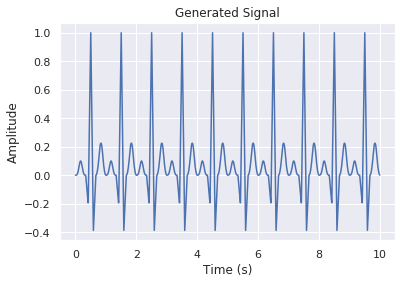

In [6]:
# Robert Waxman
# Lab 1 (9 AM Thursday)
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
np.random.seed(10)
# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a synthetic ECG template of unit length (support).

    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)


# ============================================================================
# Start your code below this line
# ============================================================================
# ...
split_second = []
wavepoints = []
fs = 256
T = 1/fs
time = np.arange(0,1,1/256)
wave = ecg_wave(time)

spikes = [0] * 2560
for n in range(10):
  spikes[n*256 + 128] = 1
total_time = np.arange(0,10,1/256)
spike_train = (np.convolve(spikes,wave, mode = 'same'))
plt.plot(total_time, spike_train)
plt.title('Generated Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


* **Simulate Noise -** Generate a noisy version of the synthetic ECG signal generated before by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations. Can you identify the locations of the QRS-complex?

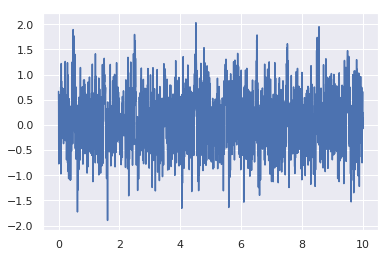

In [7]:
# 
# noise a function
# Parameters s = sigma, N = size, x = original signal
def get_noisy_signal(s, N, x):

    # generate noise
    n = s*np.random.randn(N)
    
    # return noisy signal
    return x+n
  
noised = get_noisy_signal(0.5, 2560, spike_train)
plt.plot(total_time, noised)


**Can you identify the locations of the QRS-complex?**

After adding the noise to the signal, I can vaguely make out the spikes, but the QRS complex is no longer distinguishable.

* **Find Peaks -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. We recommend that you normalize the signal before thresholding. For instance, you can normalize the signal to take values in the range $[0,1]$ or you could standardize the signal by making it zero mean and unit variance. After normalization define a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function.

Text(0, 0.5, 'Amplitude')

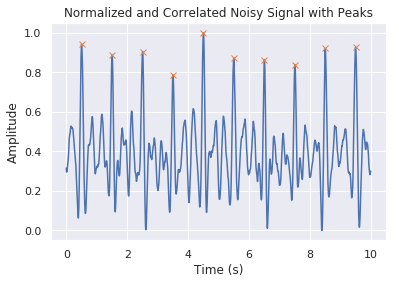

In [8]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:
        
        return x

# ...

corr = np.correlate(noised, wave, mode = 'same')
normalized_corr = normalize_range(corr)

plt.figure()
plt.title('Normalized and Correlated Noisy Signal with Peaks')
plt.plot(total_time, normalized_corr)
peaks, _ = signal.find_peaks(normalized_corr, height=0.7)
plt.plot(peaks/256, normalized_corr[peaks], 'x')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')




* **RR Intervals -** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number of peaks detected. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


R average = 0.900000 seconds
Estimated BPM = 66.666667


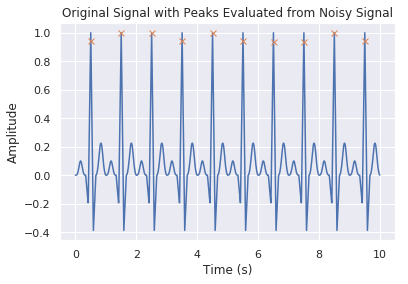

In [9]:
# ...
plt.figure()
plt.title('Original Signal with Peaks Evaluated from Noisy Signal')
plt.plot(total_time, spike_train)
plt.plot(peaks/256, spike_train[peaks], 'x')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

R = 0
for x in range(len(peaks/256) - 1):
  R += (peaks[x+1]/256 - peaks[x]/256)
R = R / len(peaks/256)
print('R average = %f seconds' %R)
BPM = 60 / R
print('Estimated BPM = %f' %BPM)


### QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal where we don't know a priori the shape of the QRS-complex waeform. There are different
sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal
noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy 
individual where signal distortion comes solely from the acquisition process. The procedure that we
will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins
algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

* **Effect of noise** - Load the signal **ecg_mitnst.json** and plot the signal over time. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

In [10]:
# access files stored on Google Drive from Colab
from google.colab import drive
drive.mount('gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive/


{'fs': 360, 'time': [0.0, 0.002777777777777778, 0.005555555555555556, 0.008333333333333333, 0.011111111111111112, 0.013888888888888888, 0.016666666666666666, 0.019444444444444445, 0.022222222222222223, 0.025, 0.027777777777777776, 0.030555555555555555, 0.03333333333333333, 0.03611111111111111, 0.03888888888888889, 0.041666666666666664, 0.044444444444444446, 0.04722222222222222, 0.05, 0.05277777777777778, 0.05555555555555555, 0.058333333333333334, 0.06111111111111111, 0.06388888888888888, 0.06666666666666667, 0.06944444444444445, 0.07222222222222222, 0.075, 0.07777777777777778, 0.08055555555555556, 0.08333333333333333, 0.08611111111111111, 0.08888888888888889, 0.09166666666666666, 0.09444444444444444, 0.09722222222222222, 0.1, 0.10277777777777777, 0.10555555555555556, 0.10833333333333334, 0.1111111111111111, 0.11388888888888889, 0.11666666666666667, 0.11944444444444445, 0.12222222222222222, 0.125, 0.12777777777777777, 0.13055555555555556, 0.13333333333333333, 0.1361111111111111, 0.13888

Text(0, 0.5, 'Voltage')

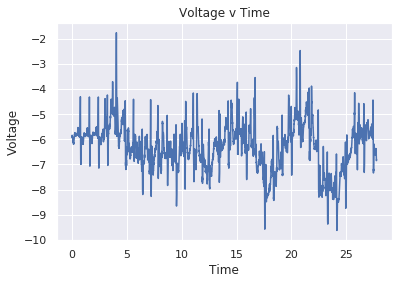

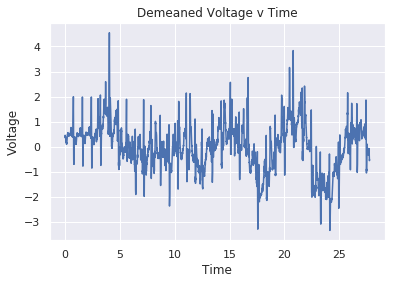

In [11]:
# load data from Google Drive
with open('gdrive/My Drive/bmdslab/lab-01/ecg_mitnst.json','r') as infile:
    data = json.load(infile)

    # print data to see dictionary fields
    print(data)

fs = data["fs"]
time = data["time"]
tk = data["tk"]
orig_voltage = data["voltage"]
plt.plot(time, orig_voltage)
plt.title('Voltage v Time')
plt.xlabel('Time')
plt.ylabel('Voltage')

total_voltage = 0;
for x in orig_voltage:
  total_voltage += x
mean_volt = total_voltage / len(orig_voltage)

voltage = np.add(orig_voltage, -1 * mean_volt)

plt.figure()
plt.plot(time, voltage)
plt.title('Demeaned Voltage v Time')
plt.xlabel('Time')
plt.ylabel('Voltage')



* **Pan-Tompkins Algorithm -** In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

  1. _Bandpass filtering:_ Follow the steps described in the manual in order to perform a bandpass filtering operation as the concatenation of lowpass and highpass filtering operations. Display the obtained signals at the intermediate steps.
  
  2. _Differentiation:_ Use the discrete filter $d_n$ to approximate the derivative of the underlying signal:
  
    $$ d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big) $$
  
    The filter is intended to localize the steepest region in the QRS-complex.
  
  3. _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform. On the squared signal use an averaging filter of length $L=20$. Why was squaring helpful in revealing the peaks of the QRS complex?
  
  3. _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal.
  
  4. _Peak detection:_ Use a peak detector to reveal the locations of the peaks. Estimate the average $RR$ interval and plot the sequence of estimated peaks.
 

Note that I used the demeaned voltage for the following questions


Text(0, 0.5, 'Voltage')

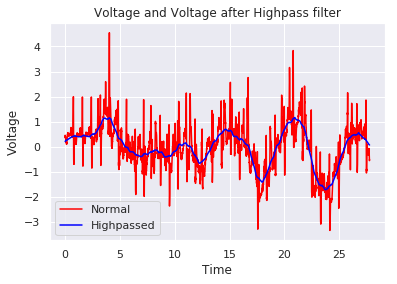

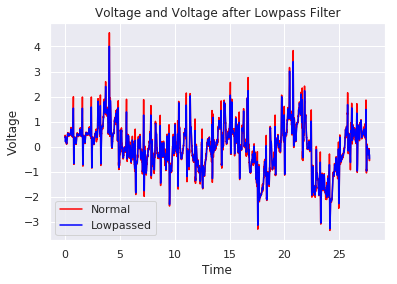

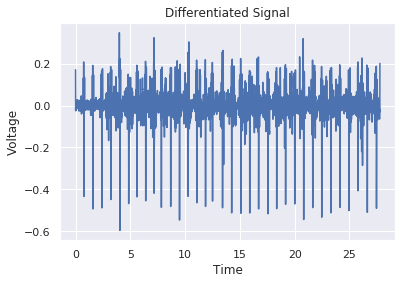

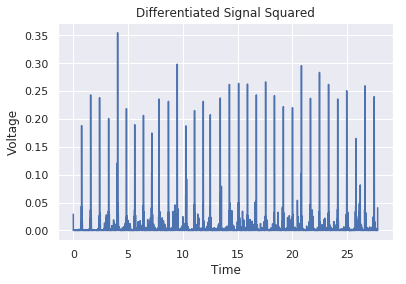

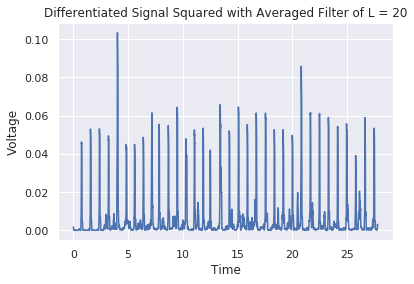

In [17]:
# ...
#1 - Bandpass Filtering:
###################
print("Note that I used the demeaned voltage for the following questions")
#Highpass Filtering:
square = [1]*500
sum = 0
triangle = np.convolve(square,square,mode = 'same')
for n in triangle:
  sum += n
triangle = triangle / sum
highpassed = np.convolve(triangle, voltage, mode = 'same')
plt.figure()
plt.title('Voltage and Voltage after Highpass filter')
plt.plot(time, voltage, 'red')
plt.plot(time, highpassed, 'blue')
plt.legend(['Normal', 'Highpassed'])
plt.xlabel('Time')
plt.ylabel('Voltage')

#Lowpass Filtering:
square = [.1]*10
lowpassed = np.convolve(square,voltage,mode = 'same')
plt.figure()
plt.title('Voltage and Voltage after Lowpass Filter')
plt.plot(time, voltage,'red')
plt.plot(time, lowpassed, 'blue')
plt.legend(['Normal', 'Lowpassed'])
plt.xlabel('Time')
plt.ylabel('Voltage')

#2 - Differentiation
####################

dn = [1/8 , 2/8, 0 , -2/8, -1/8]
diff = np.convolve(dn, voltage, mode = 'same')
plt.figure()
plt.title('Differentiated Signal')
plt.plot(time, diff)
plt.xlabel('Time')
plt.ylabel('Voltage')


#3 - Signal Squaring
#####################
diffsquared = pow(diff, 2)

plt.figure()
plt.title('Differentiated Signal Squared')
plt.plot(time, diffsquared)
plt.xlabel('Time')
plt.ylabel('Voltage')


square_for_square = [.05]*20
diff_avg = np.convolve(square_for_square, diffsquared, mode = 'same')
plt.figure()
plt.title('Differentiated Signal Squared with Averaged Filter of L = 20')
plt.plot(time, diff_avg)
plt.xlabel('Time')
plt.ylabel('Voltage')


##Why was squaring helpful in revealing the peaks of the QRS complex?

###Squaring was helpful in revealing the peaks because it intensifies the differences in values. Noise when squared will be much smaller in comparison to peaks when squared so the data will be more easily readable and the peaks will be much more easily identifiable

Text(0, 0.5, 'Voltage')

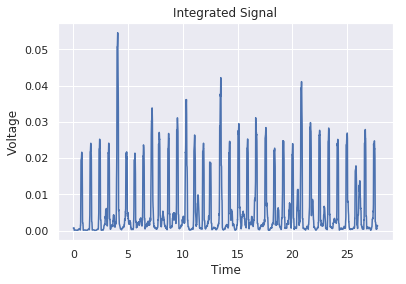

In [19]:
#4 - Integration
###############

box_4 = [0.02]*50
integrated = np.convolve(box_4, diffsquared, mode = 'same')
plt.figure()
plt.title('Integrated Signal')
plt.plot(time, integrated)
plt.xlabel('Time')
plt.ylabel('Voltage')



Text(0, 0.5, 'Amplitude')

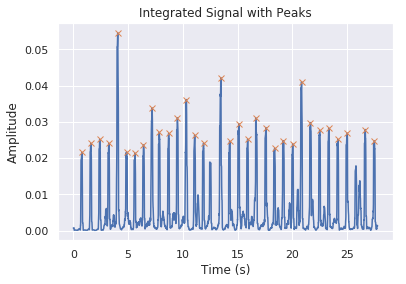

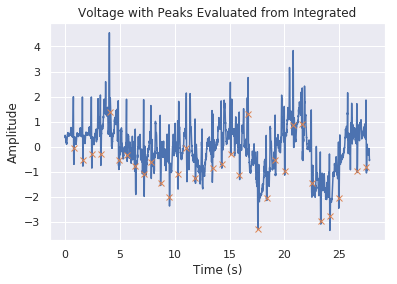

In [14]:
#5 - Peak - Detection
#####################

peaks2, _ = signal.find_peaks(integrated, height=0.02, distance = 100)
plt.figure()
plt.plot(time, integrated)
plt.plot(peaks2/360, integrated[peaks2], 'x')
plt.title('Integrated Signal with Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#USE THE INTEGRATED SIGNAL

plt.figure()
plt.plot(time, voltage)
plt.plot(peaks2/360, voltage[peaks2], 'x')
plt.title('Voltage with Peaks Evaluated from Integrated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

### Mobile health
In this last task we will consider the estimation of the heart rate in a less controlled scenario. In this case,
the signal comes from a mobile device and it is not a one-dimensional time-series but a video recording. Those with a
smartphone can record and use their own signals for the experiment. Alternatively, you can use the video
provided for that purpose. The recorded signal consists of a video of the tip of the finger placed
right in front of the camera while the camera flash is on. Play this video on your notebook and try to observe
the intensity variations due to the heart beat.

* Using the video signal and the methods studied in previous sections estimate the average heart rate from it.



In [15]:
import io
import base64
from IPython.display import HTML

# this code displays the video
video = io.open('gdrive/My Drive/bmdslab/lab-01/ppg_resized.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

The average heart rate based on the footage is 55.06117908787542 BPM


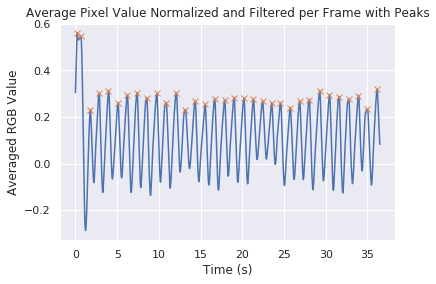

In [26]:
import cv2

# create video reader object
vread = cv2.VideoCapture("gdrive/My Drive/bmdslab/lab-01/ppg_resized.mp4")

# get number of frames
nframes = int(vread.get(cv2.CAP_PROP_FRAME_COUNT))

# get frame rate
fps = vread.get(cv2.CAP_PROP_FPS)

# loop over frames
avg = [0] * nframes
for ff in range(nframes):
    ret, img = vread.read()
    avg[ff] = np.average(img)

plt.figure()
#peaks, _ = signal.find_peaks(avg, height=82.5, distance = 10)
avg = normalize_range(avg)
box = np.ones(50)/50
triangle = np.convolve(box, box, mode = 'same')
temp = np.convolve(triangle, avg, mode = 'same')
avg = avg - temp
avg = np.convolve(square, avg, mode = 'same')
peaks, _ = signal.find_peaks(avg, height=0.1, distance = 10)
# Only made toplot because there was a unique error I had never seen
# before when trying to plot with just the peaks about not being a
# scalar integer array. Not sure why and stack was no help, but
# managed to work around it.
toplot = []
count = 0;
for x in peaks:
  toplot.append(avg[x])
total_t = nframes / fps
vid_time = []
for x in range(nframes):
  vid_time.append( x / fps)
plt.plot(vid_time, avg)
plt.plot(peaks/fps, toplot, 'x')
plt.title('Average Pixel Value Normalized and Filtered per Frame with Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Averaged RGB Value')
difference = 0
for x in range(len(peaks) - 1):
  difference += (peaks[x+1] - peaks[x])
dist_fr = difference / len(peaks)
dist_time = dist_fr / fps
hrate = 60 / dist_time
print("The average heart rate based on the footage is", hrate, "BPM")